In [4]:
import numpy as np
from dualtime.src.mclachlan import VarQITE
from gibbs.utils import create_hamiltonian_lattice,printarray,expected_state,state_from_ansatz, simple_purify_hamiltonian,expected_state, create_heisenberg
from gibbs.preparation.varqite import brute_force_optimization, pauli_rotations_ansatz
from gibbs.preparation.free_energy import brute_cmaes
from qiskit.circuit import ClassicalRegister
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp,Statevector, state_fidelity
from gibbs.learning.hamiltonian_learning import HamiltonianLearning
from scipy.linalg import expm, logm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we define a hamiltonian and a temperature. We then choose an ansatz, and perform a varqite time evolution.
We obtain ``final_state`` from the parameters yielded by varqite and theoretical_state, which is the state that we were suposed to get.

SparsePauliOp(['XXII', 'IXXI', 'IIXX', 'YYII', 'IYYI', 'IIYY', 'ZZII', 'IZZI', 'IIZZ', 'ZIII', 'IZII', 'IIZI', 'IIIZ'],
              coeffs=[ 0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
  0.25+0.j,  0.25+0.j,  0.25+0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j,
 -1.  +0.j])


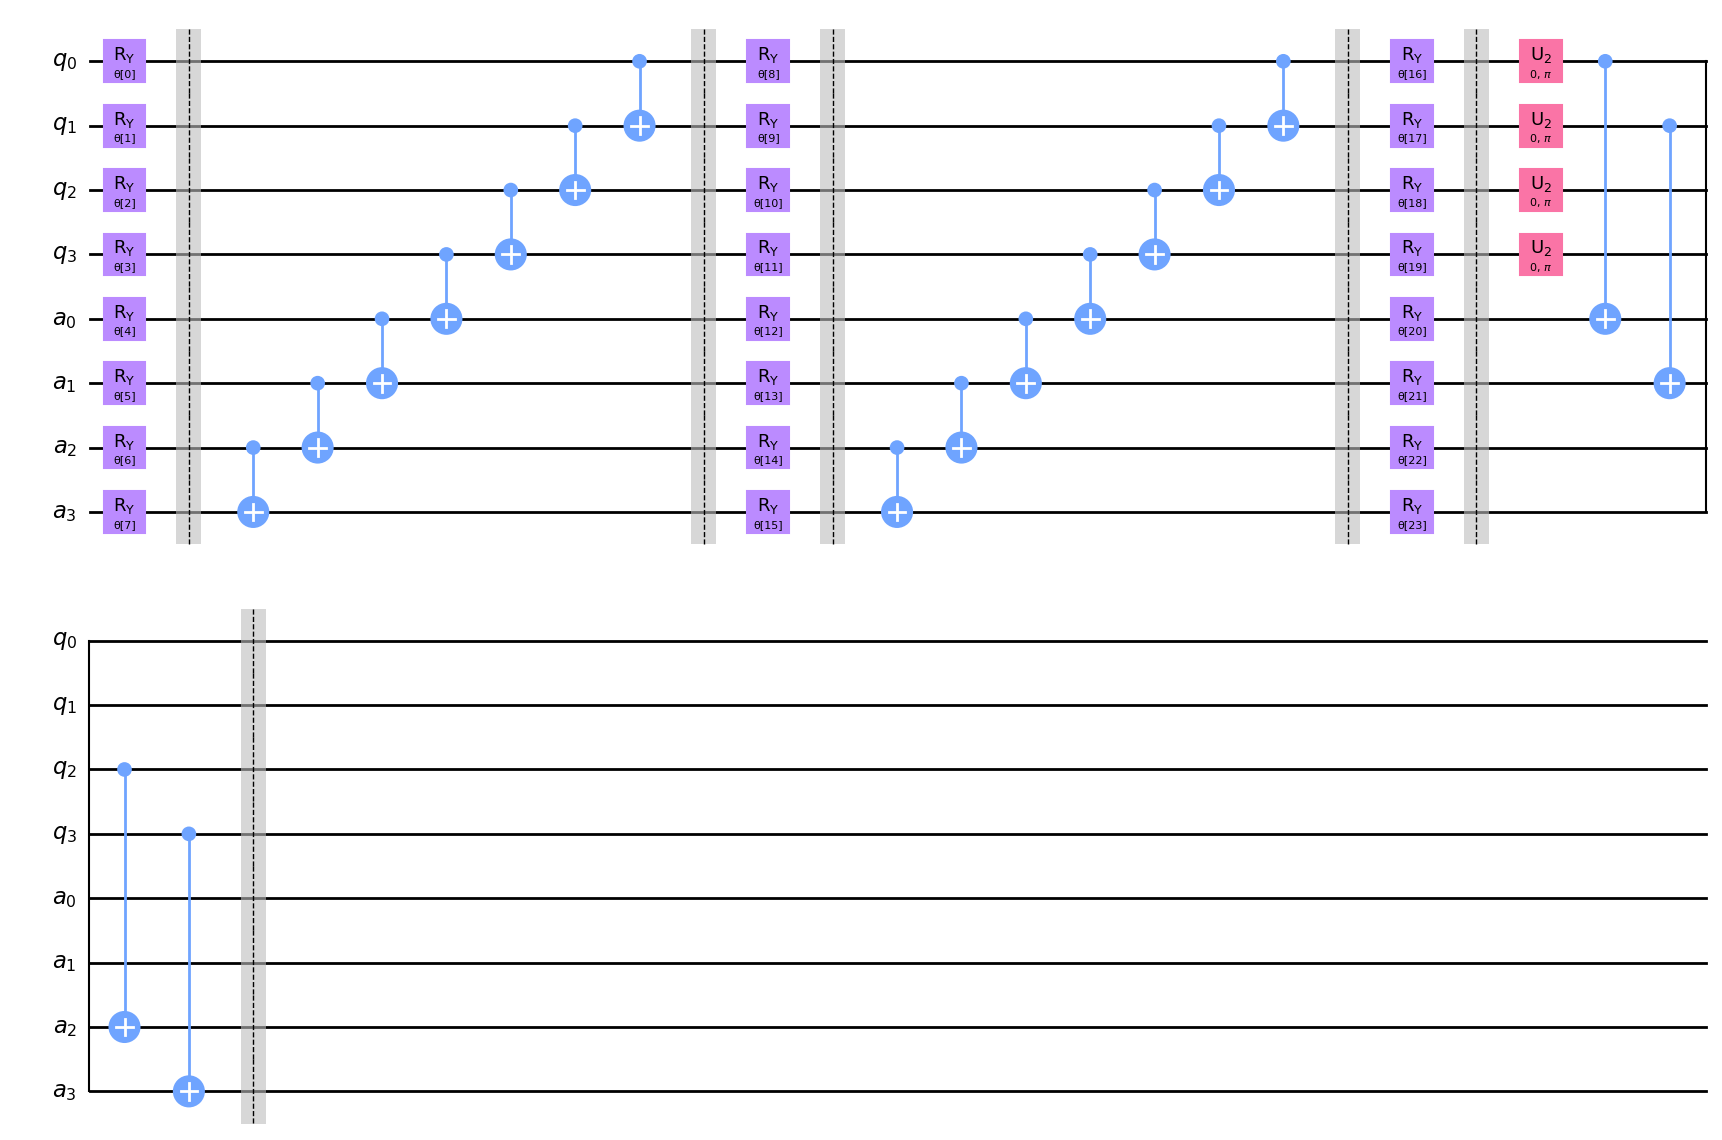

0
0.125
0.25
0.375
We have gotten a gibbs state with fidelity: 0.9687692560530448


In [5]:
beta = 1
hamiltonian = create_heisenberg(4,1/4,-1)
print(hamiltonian)
N = hamiltonian.num_qubits

ansatz,x0 = pauli_rotations_ansatz(hamiltonian,depth = 2,entanglement="reverse_linear",su2_gates=["ry"])
display(ansatz.decompose().draw(output="mpl"))
varqite = VarQITE(ansatz,x0,backend=None)
steps = 4
result_varqite = varqite.evolve(PauliSumOp(hamiltonian^("I"*N)),beta/2,timestep = beta/(2*steps))
final_state = state_from_ansatz(ansatz,result_varqite.parameters[-1])
theoretical_state = expected_state(hamiltonian,beta = 2*result_varqite.times[-1])
print("We have gotten a gibbs state with fidelity:",state_fidelity(final_state,theoretical_state))

0.5740517773228189


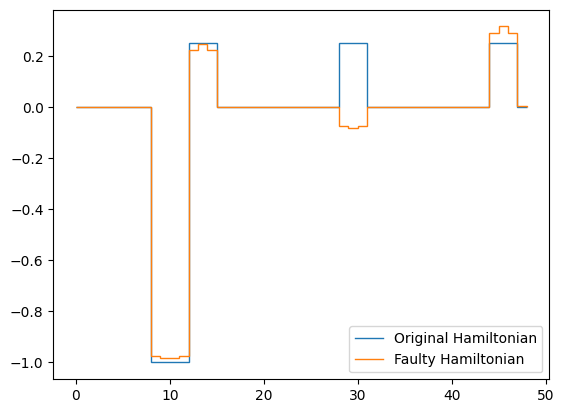

In [11]:
state = ansatz.bind_parameters(result_varqite.parameters[-1])
hl = HamiltonianLearning(state,2,3,periodic=True)    
rec_H, rec_norm = hl.classical_learn_hamiltonian()
original_vector = hl.learning_basis.pauli_to_vector(hamiltonian)
plt.stairs(original_vector,label="Original Hamiltonian")
plt.stairs(rec_Hs*rec_norms,label="Faulty Hamiltonian")
plt.legend(loc='lower right')
# plt.xticks([10,30])
print(np.linalg.norm(original_vector-rec_Hs*rec_norms))

Now that we have the parameters for the ansatz that represent our approximation of the thermal state, we bind the parameters to the ansatz. Then we perform hamiltonian learning on this circuit to see which hamiltonian is really implementing our thermal state. We print the singular values to have an estimation of how many terms we need to include in order to reconstruct the hamlitonian.

In [ ]:
hl.sample_paulis()
print("sampling done")
hl.create_constraint_matrix()
print("constraint matrix done")
hl.reconstruct_hamiltonian()
print("reconstruction done")
for i,r in enumerate(hl.singular_decomposition):
    print(i,r[0])


sampling done
constraint matrix done
reconstruction done
0 0.004239698627159886
1 0.0053167864098726085
2 0.0062228637392794574
3 0.006794777985252211
4 0.008976179806679193
5 0.011293536662890784
6 0.012500616650740908
7 0.01354330051451239
8 0.015967348581188884
9 0.018849801904943328
10 0.023906686806830776
11 0.02760987121529595
12 0.03002734395655
13 0.037674497880391976
14 0.04109497787008116
15 0.047024056366494905
16 0.05130533531138166
17 0.05712023164266829
18 0.06803800958347615
19 0.07218925296504192
20 0.07503000178286783
21 0.07850066413134393
22 0.09562526068631318
23 0.10862375230472558
24 0.12658549932596996
25 0.13302631409954538
26 0.17069892703374276
27 0.1767850053029133
28 0.20821815733482554
29 0.20999511004952573
30 0.24151268927613306
31 0.2475395742071158
32 5.133404774329525
33 5.189872472771119
34 5.238754176136105
35 5.295578816167905
36 5.369729745784756
37 5.418741905636906
38 5.431154550045319
39 5.578646292726796
40 6.6103949415963745
41 6.8710482451990

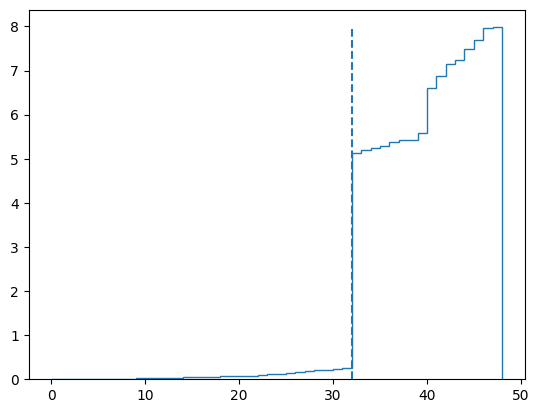

In [ ]:
k=32
singular_values = [r[0] for r in hl.singular_decomposition]
plt.stairs(singular_values)
plt.vlines(k,min(singular_values),max(singular_values),linestyles="dashed")

Most likely, we will have several terms with a small singular value. In such a case we let all of those singular vectors define a subspace. We will then project the vector corresponding to the original hamiltoninan onto this subspace. This projection will be our best guess at the faulty hamiltonian behind our faulty thermal state.

In [ ]:
projection,projection_coeffs = hl.project_hamiltonian(k,hamiltonian)
print("The average error per term in the hamiltonian is:",np.linalg.norm(projection - original_vector.T)/(len(original_vector)*np.linalg.norm(original_vector)))
print("The maximum term error is:",np.max(np.abs(projection - original_vector.T)))

The average error per term in the hamiltonian is: 0.001886130467495779
The maximum term error is: 0.08051088301839787


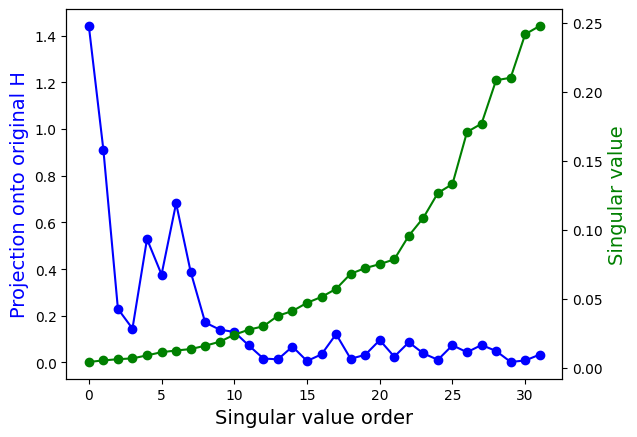

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.abs(projection_coeffs),marker = "o",color = "blue")
ax.set_xlabel("Singular value order", fontsize = 14)
ax.set_ylabel("Projection onto original H", fontsize = 14, color = "blue")
ax2=ax.twinx()
ax2.plot([r[0] for r in hl.singular_decomposition[:k]],color="green",marker="o")
ax2.set_ylabel("Singular value",color="green",fontsize=14)
plt.show()


(48,)


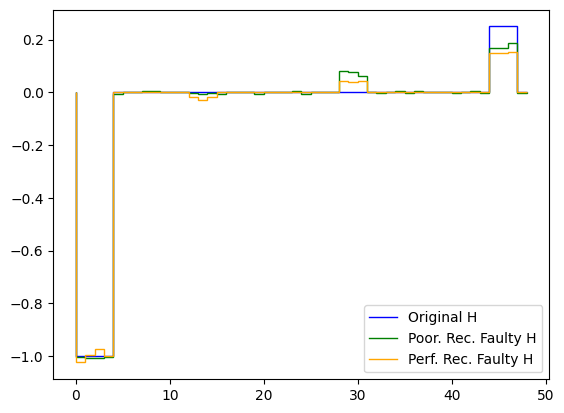

In [ ]:
print(np.asarray(projection).flatten().shape)
plt.stairs(original_vector,color="blue",label="Original H")
plt.stairs(np.asarray(projection).flatten(),color="green",label="Poor. Rec. Faulty H")
plt.stairs(perfect_reconstruction,color="orange",label="Perf. Rec. Faulty H")
plt.legend(loc="lower right")

Here we see how much better would the guess would be with a different temperature with respect to the real faulty state.

In [ ]:
from scipy.optimize import minimize
guessed_faulty_state = expected_state(beta*hl.learning_basis.vector_to_pauli_op(projection.T),beta = 1)
print(f"The state fidelity between the state that we guessed and the one that actually implemented is:{state_fidelity(guessed_faulty_state,final_state):.4f}")
#This will give us the error in temperature from the hamiltonian we found to the one we have implemented
fidelity_temperature = lambda beta : -state_fidelity(expected_state(hl.learning_basis.vector_to_pauli_op(projection.T),beta = beta),final_state)

minimization = minimize(fidelity_temperature,x0=1)
print(f"We could have gotten a fidelity of {-minimization.fun:.4f} if the temperature was multiplied by {minimization.x[0]:.4f}")

The state fidelity between the state that we guessed and the one that actually implemented is:0.9869
We could have gotten a fidelity of 0.9870 if the temperature was multiplied by 1.0164


Finally, this is the estimation that we have of the error between the original_hamiltonian and the guessed_faulty_hamiltonian.

In [ ]:
deltaH_vector = original_vector.T - projection
deltaH = hl.learning_basis.vector_to_pauli_op(deltaH_vector.T)
print("The error in the hamiltonian vector is:",np.linalg.norm(deltaH_vector,ord = 2))
print("The largest eigenvalue of deltaH is:",np.linalg.norm(deltaH.to_matrix(),ord = 2))
print("The error between the final state and the theoretical state is:",np.linalg.norm(final_state - theoretical_state, ord=2))
print("The projection of the faulty hamiltonian outside the subspace is:", 1-np.dot(projection,original_vector)/(np.linalg.norm(original_vector)*np.linalg.norm(projection)))

The error in the hamiltonian vector is: 0.18526371900275587
The largest eigenvalue of deltaH is: 0.3429283450695954
The error between the final state and the theoretical state is: 0.04714959713689411
The projection of the faulty hamiltonian outside the subspace is: [[0.00410666+0.j]]


Here we can see the hamiltoinan we would reconstruct if we could perform complete tomography over our state.

In [ ]:
deltaHs = np.zeros(len(result_varqite.times))
fidelities = np.zeros(len(result_varqite.times))
operator_norms = np.zeros(len(result_varqite.times))

for i,p,t in zip(range(len(result_varqite.times)),result_varqite.parameters,result_varqite.times):
    beta_temp = 2*t
    exp_state = expected_state(hamiltonian,beta = beta_temp)
    faulty_state = state_from_ansatz(ansatz,p)
    hl_temp = HamiltonianLearning(ansatz.bind_parameters(p) ,2,3,periodic=True)
    hl_temp.sample_paulis()
    hl_temp.create_constraint_matrix()
    hl_temp.reconstruct_hamiltonian()
    faulty_vector_estimation = hl_temp.project_hamiltonian(k,beta_temp * hamiltonian)[0]
    faulty_hamiltonian_estimation = hl_temp.learning_basis.vector_to_pauli_op(faulty_vector_estimation.T)
    faulty_state_estimation = expected_state(hamiltonian=faulty_hamiltonian_estimation,beta = 1)
    operator_norms[i] = np.linalg.norm(faulty_state_estimation - expected_state(hamiltonian,beta = beta_temp),ord = 2 )
    fidelities[i] = state_fidelity(faulty_state,exp_state)
    deltaHs[i] = np.linalg.norm(faulty_vector_estimation - beta_temp * original_vector.T)


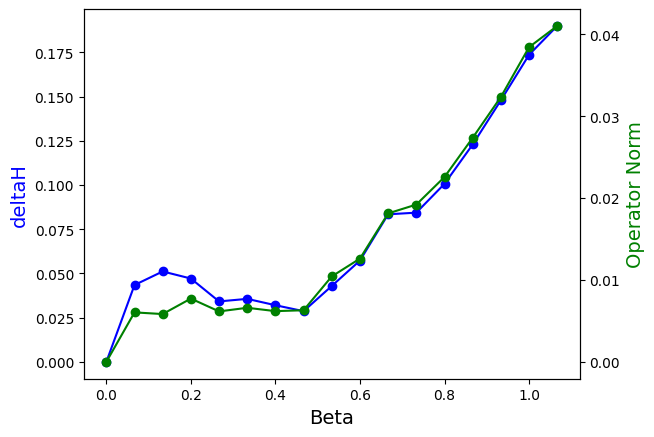

In [ ]:
fig,ax = plt.subplots()
points = None
ax.plot(2*np.array(result_varqite.times)[:points],deltaHs[:points],marker = "o",color = "blue")
ax.set_xlabel("Beta", fontsize = 14)
ax.set_ylabel("deltaH", fontsize = 14, color = "blue")
ax2=ax.twinx()
ax2.plot(2*np.array(result_varqite.times)[:points],operator_norms[:points],color="green",marker="o")
ax2.set_ylabel("Operator Norm",color="green",fontsize=14)
plt.show()

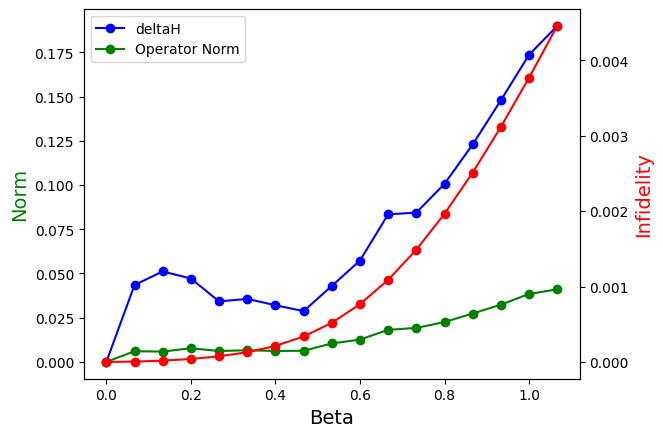

In [ ]:
fig,ax = plt.subplots()
points = None
ax.plot(2*np.array(result_varqite.times)[:points],deltaHs[:points],marker = "o",color = "blue", label = "deltaH")
ax.set_xlabel("Beta", fontsize = 14)
ax.plot(2*np.array(result_varqite.times)[:points],operator_norms[:points],color="green",marker="o", label = "Operator Norm")
ax.set_ylabel("Norm",color="green",fontsize=14)
plt.legend()
infidelities = 1 - fidelities
ax2=ax.twinx()
ax2.plot(2*np.array(result_varqite.times)[:points],infidelities[:points],color="red",marker="o",label = "Fidelity")
ax2.set_ylabel("Infidelity",color="red",fontsize=14)
infidelities = 1 - fidelities
plt.show()